In [29]:
from google.colab import drive
from google.colab import files
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.fftpack import idct
from scipy.fftpack import dct


In [30]:
with open('compressed_image.jpg', 'rb') as file:
    compressed_bitstream = file.read()

# Step 2: Locate the header and metadata
header_end_marker = compressed_bitstream.find(b'\x00\xFF')
header_data = compressed_bitstream[:header_end_marker]

# Step 3: Deserialize the 'compression_parameters' dictionary
import pickle

compression_parameters = pickle.loads(header_data)
pixel_bitstream = compressed_bitstream[header_end_marker+2:]

huffman_codes = compression_parameters['huffman_table']
quantization_matrix_y = compression_parameters['quantization_matrix_y']
quantization_matrix_cbcr = compression_parameters['quantization_matrix_cbcr']

In [31]:
print(len(pixel_bitstream))
print(huffman_codes)

25072
{(-13.0, 1): '000000000', (-3.0, 2): '000000001', (9.0, 1): '00000001', (75.0, 1): '00000010', (103.0, 1): '000000110', (134.0, 1): '0000001110', (30.0, 1): '0000001111', (7.0, 1): '0000010', (74.0, 1): '00000110', (86.0, 1): '00000111', (3.0, 1): '00001', (0.0, 48): '000100000', (34.0, 1): '0001000010', (98.0, 1): '0001000011', (100.0, 1): '0001000100', (116.0, 1): '0001000101', (131.0, 1): '000100011', (0.0, 51): '0001001', (72.0, 1): '00010100', (-12.0, 1): '000101010', (69.0, 1): '000101011', (-9.0, 1): '00010110', (93.0, 1): '000101110', (124.0, 1): '0001011110', (-1.0, 4): '00010111110', (22.0, 1): '00010111111', (0.0, 55): '000110', (71.0, 1): '00011100', (129.0, 1): '000111010', (3.0, 2): '000111011', (14.0, 1): '0001111000', (23.0, 1): '000111100100', (-24.0, 1): '000111100101', (138.0, 1): '00011110011', (39.0, 1): '0001111010', (64.0, 1): '0001111011', (112.0, 1): '0001111100', (133.0, 1): '0001111101', (137.0, 1): '0001111110', (145.0, 1): '00011111110', (150.0, 1): '

In [32]:
packaged_data = []
i = 0
while i < len(pixel_bitstream):
    # First byte represents the byte count
    byte_count = int.from_bytes(pixel_bitstream[i:i+1], byteorder='big')
    i += 1
    # Extract the byte array
    byte_array = pixel_bitstream[i:i+byte_count]
    packaged_data.append(byte_array)
    i += byte_count

In [33]:
print(len(packaged_data))
print((packaged_data[0]))

1024
b'\x03\x03\x02\x9c\xcd\x03\x025\xbc\xcd\x03\x01\x0f\xbc\xcd'


In [34]:
encoded_blocks = []
for package in packaged_data:
  i = 0
  single_block = []
  while i < len(package):
    # First byte represents the byte count
    byte_count = int.from_bytes(package[i:i+1], byteorder='big')
    i += 1
    # Extract the leading_zero_count
    leading_zero_count = int.from_bytes(package[i:i+1], byteorder='big')
    i += 1
    # Extract the byte array
    byte_array = package[i:i+byte_count]
    b_string = ''.join(format(byte, '08b') for byte in byte_array)
    binary_string = b_string[leading_zero_count:]
    single_block.append(binary_string)
    i += byte_count
  encoded_blocks.append(single_block)

In [35]:
print(np.array(encoded_blocks).shape)
print((encoded_blocks[0]))

(1024, 3)
['000101001110011001101', '1101011011110011001101', '00011111011110011001101']


In [36]:
print((encoded_blocks[4][2]))

1011011110001010100011110100


In [37]:
rle_encoded_blocks = []

for encoded_block in encoded_blocks:
    rle_encoded_block = []
    for encoded_channel in encoded_block:
        rle_channel_data = []
        code = ''
        for bit in encoded_channel:
            code += bit
            for symbol, huff_code in huffman_codes.items():
                if code == huff_code:
                    rle_channel_data.append(symbol)
                    code = ''
        rle_encoded_block.append(rle_channel_data)
    rle_encoded_blocks.append(rle_encoded_block)

In [38]:
print(np.array(rle_encoded_blocks).shape)
print(rle_encoded_blocks[0][0])

(1024, 3)
[(72.0, 1), (0.0, 1), (1.0, 1), (0.0, 61)]


<ipython-input-38-2afc18c31c32>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.array(rle_encoded_blocks).shape)


In [39]:
def de_zigzag_scan(result):
    # print(len(result))
    h, w = (8,8)
    matrix = [[0] * 8 for _ in range(8)]
    x, y = 0, 0
    for i in range(h * w):
        tmp = result[i]
        matrix[x][y] = tmp
        if (x + y) % 2 == 0:  # Upward
            if x == 0 and y!=w-1:
                y += 1
            elif y == w - 1:
                x += 1
            else:
                y += 1
                x -= 1
        else:  # Downward
            if y == 0 and x!=h-1:
                x += 1
            elif x == h - 1:
                y += 1
            else:
                y -= 1
                x += 1
    return matrix

def expand_rle(rle_data):
    expanded_data = []
    for value, run_length in rle_data:
        expanded_data.extend([value] * run_length)
    return expanded_data

# Expand RLE data for each element in the array
expanded_linear_array = np.zeros(shape=(1024,8,8,3))

for i in range(len(rle_encoded_blocks)):
    for c in range(3):
        channel_data = rle_encoded_blocks[i][c]
        # print("infb: ", channel_data)
        expanded_channel = expand_rle(channel_data)
        # print("inf: ", len(expanded_channel))
        expanded_channel_matrix = de_zigzag_scan(expanded_channel)
        expanded_linear_array[i,:,:,c] = expanded_channel_matrix




In [40]:
ex = np.zeros(shape=(1024,8,8,3))
ex.shape

(1024, 8, 8, 3)

In [41]:
print(np.array(expanded_linear_array).shape)
print(np.array(expanded_linear_array)[1,:,:,1])

(1024, 8, 8, 3)
[[86.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]


In [42]:
dequantized_blocks = np.zeros(shape=(1024,8,8,3))
for i in range(len(expanded_linear_array)):
  for c in range(3):
    channel = expanded_linear_array[i,:,:,c]
    if c==0:
      dequantized_channel = channel*quantization_matrix_y/10
    else:
      dequantized_channel = channel*quantization_matrix_cbcr/10
    dequantized_blocks[i,:,:,c] = dequantized_channel
  # dequantized_blocks.append(dequantized_channels)

In [43]:
print(np.array(dequantized_blocks[1,:,:,1]))
dequantized_blocks = np.array(dequantized_blocks)

[[146.2   0.    0.    0.    0.    0.    0.    0. ]
 [  0.    0.    0.    0.    0.    0.    0.    0. ]
 [  0.    0.    0.    0.    0.    0.    0.    0. ]
 [  0.    0.    0.    0.    0.    0.    0.    0. ]
 [  0.    0.    0.    0.    0.    0.    0.    0. ]
 [  0.    0.    0.    0.    0.    0.    0.    0. ]
 [  0.    0.    0.    0.    0.    0.    0.    0. ]
 [  0.    0.    0.    0.    0.    0.    0.    0. ]]


In [16]:
def inverse_dct_block(block):
    return idct(idct(block, axis=0, norm='ortho'), axis=1, norm='ortho')

# Apply inverse DCT to all blocks
idct_blocks = np.zeros_like(dequantized_blocks)

for block_index in range(1024):
    for channel in range(3):
        channel_block = dequantized_blocks[block_index, :, :, channel]
        idct_channel_block = inverse_dct_block(channel_block)
        idct_blocks[block_index,:,:,channel] = idct_channel_block
    # idct_blocks.append(idct_block)

# Convert the list to a NumPy array
# idct_blocks = np.array(idct_blocks)

In [17]:
print(idct_blocks.shape)
print(idct_blocks[1,:,:,1])

(1024, 8, 8, 3)
[[18.275 18.275 18.275 18.275 18.275 18.275 18.275 18.275]
 [18.275 18.275 18.275 18.275 18.275 18.275 18.275 18.275]
 [18.275 18.275 18.275 18.275 18.275 18.275 18.275 18.275]
 [18.275 18.275 18.275 18.275 18.275 18.275 18.275 18.275]
 [18.275 18.275 18.275 18.275 18.275 18.275 18.275 18.275]
 [18.275 18.275 18.275 18.275 18.275 18.275 18.275 18.275]
 [18.275 18.275 18.275 18.275 18.275 18.275 18.275 18.275]
 [18.275 18.275 18.275 18.275 18.275 18.275 18.275 18.275]]


In [18]:
num_blocks_h = 32  # Number of blocks in the height (rows)
num_blocks_w = 32  # Number of blocks in the width (columns)

pixel_array = idct_blocks.reshape(num_blocks_h, num_blocks_w, 8, 8, 3).transpose(0, 2, 1, 3, 4).reshape(num_blocks_h * 8, num_blocks_w * 8, 3)


In [19]:
print(pixel_array.shape)

(256, 256, 3)


In [20]:
rgb_to_ycbcr = np.array([[0.299, 0.587, 0.114],
                        [-0.168736, -0.331264, 0.5],
                        [0.5, -0.418688, -0.081312]])

def ycbcr_to_rgb(color_m):
  M = [[0.2126*(219/255) , 0.7152*(219/255) , 0.0722*(219/255)],
     [-(0.2126/1.18556)*(224/255) , (0.7152/1.8556)*(224/255) , 0.5*(219/255)],
     [0.5*(224/255) , (0.7152/1.5748)*(224/255) , (0.0722/1.5748)*(224/255)]]

  K = [[16], [128], [128]]

  res = np.dot(np.linalg.inv(M),(color_m.T-K))

  # Clip the values to the [0, 255] range
  res = (np.round(np.clip(res, 0, 255)))

  return res

In [21]:
pixel_array_rgb = []
for i in range(len(pixel_array)):
  col_rgb = []
  for j in range(len(pixel_array[i])):
    x = np.array([pixel_array[i][j]])
    tmp = np.transpose(ycbcr_to_rgb(x))

    col_rgb.append([tmp[0][0], tmp[0][1], tmp[0][2]])
  pixel_array_rgb.append(col_rgb)


In [22]:
pixel_array_rgb = np.array(pixel_array_rgb)
pixel_array_rgb /= 255

In [23]:
print(np.array(pixel_array_rgb).shape)
print(pixel_array_rgb[35])

(256, 256, 3)
[[0.         0.54509804 0.        ]
 [0.         0.54117647 0.        ]
 [0.         0.54117647 0.        ]
 [0.         0.54117647 0.        ]
 [0.         0.54117647 0.        ]
 [0.         0.5372549  0.        ]
 [0.         0.52941176 0.        ]
 [0.         0.5254902  0.        ]
 [0.         0.51764706 0.        ]
 [0.         0.50980392 0.        ]
 [0.         0.50196078 0.        ]
 [0.         0.50196078 0.        ]
 [0.         0.50588235 0.        ]
 [0.         0.51764706 0.        ]
 [0.         0.52156863 0.        ]
 [0.         0.5254902  0.        ]
 [0.         0.53333333 0.        ]
 [0.         0.5372549  0.        ]
 [0.         0.54117647 0.        ]
 [0.         0.54509804 0.        ]
 [0.         0.54117647 0.        ]
 [0.         0.54117647 0.        ]
 [0.         0.54117647 0.        ]
 [0.         0.54117647 0.        ]
 [0.         0.54117647 0.        ]
 [0.         0.5372549  0.        ]
 [0.         0.5372549  0.        ]
 [0.         0

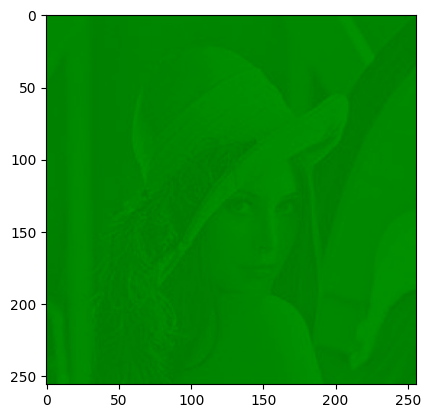

In [28]:
plt.imshow(pixel_array_rgb, cmap='gray')